In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import time
import math
from sklearn.metrics import accuracy_score
from utils import *
from preprocessing import load_data
from RandomFeats import define_rand_feats
from DirectionalMLP import mlp_main, generate

In [2]:
### CONFIG
task = 'potency'
K = 64 # Num pca components
percentile = 35 # Upper pth percentile for subsets
N = 1280 # Num betas to fit (Typically 512 or 1280)
M = 25_000 # Num betas to generate
batch_size = 64
ndirs_values = [1, 5, 25, 101, 251] # Number directions to use for each datapoints personalized ensemble

In [3]:
data = load_data(task, K)

In [4]:
np.random.seed(74)
X, _ = data['train']
D = K * 5
model = define_rand_feats(X, D)

In [6]:
### Load sample betas and dirs
id_str = f"{task}-N{N}-D{D}-perc{percentile}-pca{K}"
dirs = np.load('sample_data/directional/fit/' + id_str + '-dirs.npy')
betas = np.load('sample_data/directional/fit/' + id_str + '-betas.npy')

print(dirs.shape)
print(betas.shape)

(1280, 64)
(1280, 3201)


In [7]:
# Beta Model
mlp_ret = mlp_main(np.array(dirs), np.array(betas), X, model(X), percentile)
print(f"MLP Metrics:\n\tTest Loss - {mlp_ret['test_loss']}\n\Agreement: Overall - {mlp_ret['overall_agreement']}, Subset - {mlp_ret['subset_agreement']}")

Epoch 1/10


c:\ProgramData\anaconda3\envs\EveryDirHoldsSoln\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1301
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1049
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0971
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0919
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0891
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0875
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0862
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0855
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0849
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0845
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0824  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MLP Metrics:
	Test Loss - 0.08242389559745789
\Agreement: Overall - 0.7153091532797858, Subset - 0.717992159548327


In [8]:
# Draw new betas
gen_dirs, gen_betas = generate(mlp_ret['mlp'], M, K)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [9]:
X_iid, Y_iid = data['iid_val']
X_ood_val, Y_ood_val = data['ood_val']
X_ood_test, Y_ood_test = data['ood_test']

X_iid_rand = model(X_iid)
X_ood_val_rand = model(X_ood_val)
X_ood_test_rand = model(X_ood_test)

In [10]:
# Function to find the indices of the top ndirs closest directions
def get_dirs_idxs(x_batch, dirs, ndirs):
    # x_batch: (batch_size, d), dirs: (M, d)
    # proj: (batch_size, M)
    proj = tf.matmul(x_batch, dirs, transpose_b=True)
    # Get top 'ndirs' indices for each batch
    return tf.argsort(proj, axis=1, direction='DESCENDING')[:, :ndirs]

In [11]:
def dir_ens(X, X_rand, Y, dirs, betas):
    n = X.shape[0]
    # Add dummy dim for bias term in log reg
    X_rand = np.concatenate([np.ones((n, 1)), X_rand], axis=1)
    accuracies = []
    start_time = time.time()

    # Very inefficient since directions for 1, 5, ..., 501 are found in 1001
    # Could just do it once and grab all of them
    # But this is simpler impl for now
    for j, ndirs in enumerate(ndirs_values):
        preds = []
        round_start_time = time.time()
        for i in range(0, n, batch_size):
            end_i = i + batch_size if (i + batch_size) < n else n
            x_batch = X[i:end_i]  # (batch_size, K)
            batch_indices = get_dirs_idxs(x_batch, dirs, ndirs)  # (batch_size, ndirs)
            x_rand_batch = X_rand[i:end_i]  # (batch_size, r+1)
            betas_batch = tf.cast(tf.gather(betas, batch_indices, axis=0), tf.float64)  # (batch_size, ndirs, r+1)
            preds_batch = tf.matmul(x_rand_batch[:, None, :], betas_batch, transpose_b=True)
            preds_batch = tf.squeeze(preds_batch)  # (batch_size, ndirs)
            preds.append(preds_batch)

            if i % 25 == 0:
                print(f"Round {j} - Processed batch {i//batch_size + 1}")
                curr_time = time.time()
                elapsed_time = (curr_time - round_start_time)/60 # min
                print(f"\t\tTime Elapsed: {elapsed_time:.2f} min - est {elapsed_time/(i//batch_size + 1)*math.ceil(N/batch_size) - elapsed_time:.2f} min remaining in round {j}")

        preds = tf.concat(preds, axis=0)  # (n, ndirs)
        final_preds, _, _ = aggregate_preds(preds)
        acc = accuracy_score(Y, final_preds)
        accuracies.append(acc)

        print(f"Accuracy for {ndirs} directions: {acc}")
        elapsed_time = (time.time() - start_time)/60 # min
        print(f"Round {j} Time Elapsed: {elapsed_time:.2f} min - est {elapsed_time/(j+1)*len(ndirs_values) - elapsed_time:.2f} min remaining")
        print()
    return accuracies

def plot(accs):
    plt.plot(ndirs_values, accs, marker='o')
    plt.xlabel('Number of Directions (ndirs)')
    plt.ylabel('IID Accuracy')
    plt.title('IID Accuracy vs Number of Directions')
    plt.grid(True)
    plt.show()

In [12]:
iid_accs = dir_ens(X_iid, X_iid_rand, Y_iid, gen_dirs, gen_betas)

Round 0 - Processed batch 1
		Time Elapsed: 0.00 min - est 0.02 min remaining in round 0
Round 0 - Processed batch 26
		Time Elapsed: 0.01 min - est -0.00 min remaining in round 0
Round 0 - Processed batch 51
		Time Elapsed: 0.03 min - est -0.02 min remaining in round 0
Accuracy for 1 directions: 0.5189125295508275
Round 0 Time Elapsed: 0.03 min - est 0.14 min remaining

Round 1 - Processed batch 1
		Time Elapsed: 0.00 min - est 0.01 min remaining in round 1
Round 1 - Processed batch 26
		Time Elapsed: 0.02 min - est -0.00 min remaining in round 1
Round 1 - Processed batch 51
		Time Elapsed: 0.03 min - est -0.02 min remaining in round 1
Accuracy for 5 directions: 0.5288416075650119
Round 1 Time Elapsed: 0.08 min - est 0.12 min remaining

Round 2 - Processed batch 1
		Time Elapsed: 0.00 min - est 0.02 min remaining in round 2
Round 2 - Processed batch 26
		Time Elapsed: 0.02 min - est -0.01 min remaining in round 2
Round 2 - Processed batch 51
		Time Elapsed: 0.04 min - est -0.03 min re

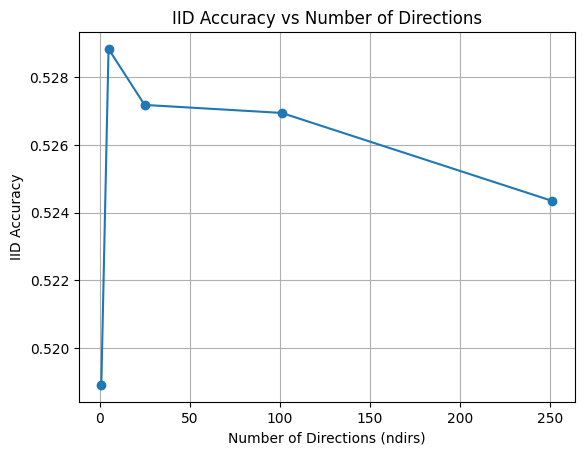

In [13]:
plot(iid_accs)

In [ ]:
ood_val_accs = dir_ens(X_ood_val, X_ood_val_rand, Y_ood_val, gen_dirs, gen_betas)

Round 0 - Processed batch 1
		Time Elapsed: 0.00 min - est 0.00 min remaining in round 0
Round 0 - Processed batch 26
		Time Elapsed: 0.00 min - est -0.00 min remaining in round 0
Round 0 - Processed batch 51
		Time Elapsed: 0.00 min - est -0.00 min remaining in round 0
Round 0 - Processed batch 76
		Time Elapsed: 0.00 min - est -0.00 min remaining in round 0
Round 0 - Processed batch 101
		Time Elapsed: 0.01 min - est -0.01 min remaining in round 0
Accuracy for 1 directions: 0.5066240292370946
Round 0 Time Elapsed: 0.01 min - est 0.03 min remaining

Round 1 - Processed batch 1
		Time Elapsed: 0.00 min - est 0.00 min remaining in round 1
Round 1 - Processed batch 26
		Time Elapsed: 0.00 min - est -0.00 min remaining in round 1
Round 1 - Processed batch 51
		Time Elapsed: 0.00 min - est -0.00 min remaining in round 1
Round 1 - Processed batch 76
		Time Elapsed: 0.01 min - est -0.01 min remaining in round 1
Round 1 - Processed batch 101
		Time Elapsed: 0.01 min - est -0.01 min remaining 

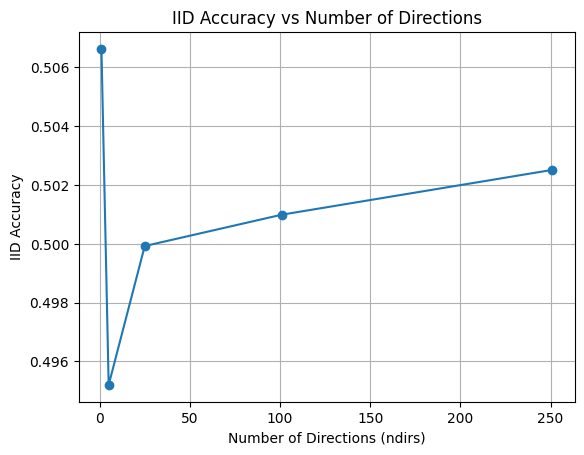

In [ ]:
plot(ood_val_accs)

In [ ]:
ood_test_accs = dir_ens(X_ood_test, X_ood_test_rand, Y_ood_test, gen_dirs, gen_betas)

Round 0 - Processed batch 1
		Time Elapsed: 0.00 min - est 0.00 min remaining in round 0
Round 0 - Processed batch 26
		Time Elapsed: 0.00 min - est -0.00 min remaining in round 0
Round 0 - Processed batch 51
		Time Elapsed: 0.00 min - est -0.00 min remaining in round 0
Round 0 - Processed batch 76
		Time Elapsed: 0.00 min - est -0.00 min remaining in round 0
Round 0 - Processed batch 101
		Time Elapsed: 0.01 min - est -0.00 min remaining in round 0
Accuracy for 1 directions: 0.5020219526285384
Round 0 Time Elapsed: 0.01 min - est 0.03 min remaining

Round 1 - Processed batch 1
		Time Elapsed: 0.00 min - est 0.00 min remaining in round 1
Round 1 - Processed batch 26
		Time Elapsed: 0.00 min - est -0.00 min remaining in round 1
Round 1 - Processed batch 51
		Time Elapsed: 0.00 min - est -0.00 min remaining in round 1
Round 1 - Processed batch 76
		Time Elapsed: 0.01 min - est -0.00 min remaining in round 1
Round 1 - Processed batch 101
		Time Elapsed: 0.01 min - est -0.01 min remaining 

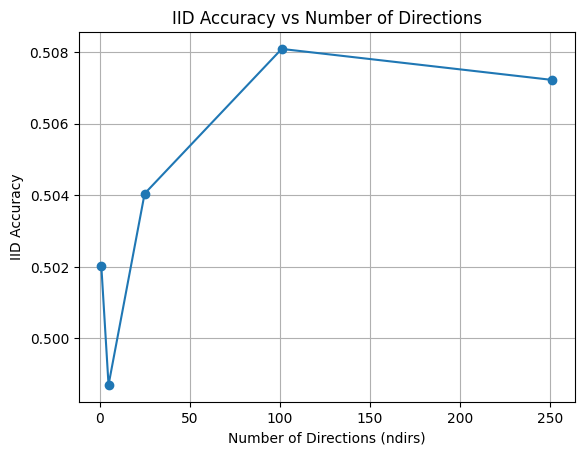

In [ ]:
plot(ood_test_accs)